# Building a customized NER for Course Recommender


`Description`

NER stands for Named Entity Recognition. It is a subtask of Natural Language Processing (NLP) that involves identifying and extracting named entities from unstructured text. Named entities are specific pieces of information that are mentioned in the text and refer to real-world objects such as people, places, organizations, and dates.

The goal of NER is to automatically identify and classify these named entities in a given text. This can be useful in many applications, such as information extraction, question answering, and sentiment analysis. NER systems typically use machine learning algorithms, such as Conditional Random Fields (CRFs) or Recurrent Neural Networks (RNNs), to automatically identify and label named entities in text.

In this notebook, we collect all the training data, prepare it for a NER model and train the model. The final output of this notebook would be a trained custom NER model that would extract Course Name related entities such as abbreviation, full-name etc.

E.g.

`Input Q`: "*Im looking for all the items similar to applied data sci, are there any?*"

`NER Model Output`: "applied data sci"

This output would be used to search for a matching index in ElasticSearch DB, and would return a UUID mapped to "Applied Data Science" course.

---
Contents:

---

# Citations

Used for generating training data:
- Alexa API: https://developer.amazon.com/en-US/docs/alexa/alexa-smart-properties/alexa-for-residential-endpoint-api.html
- ChatGPT Warpper: https://github.com/acheong08/ChatGPT

# Imports

In [2]:
## Imports
'''Python Version 3.8.0'''

# Standard libs
import os
import sys
import json
import warnings
import yaml
import re
import io
from io import StringIO
import inspect
import shutil
import random
import ast
import string
import time
import pickle
import glob
import traceback
import multiprocessing
import requests
import logging
from ast import literal_eval
import math
import pytz
from itertools import chain
from string import Template
from datetime import datetime, timedelta
from dateutil import parser
import base64
from collections import defaultdict, Counter, OrderedDict
from contextlib import contextmanager
import unicodedata
from functools import reduce
import itertools
import tempfile
from typing import Any, Dict, List, Callable, Optional, Tuple, NamedTuple, Union
from functools import wraps

# Required pkgs
import numpy as np
from numpy import array, argmax
import pandas as pd
import ntpath
import tqdm

# General text correction - fit text for you (ftfy) and others
import ftfy
from fuzzywuzzy import fuzz
from spellchecker import SpellChecker

# scikit-learn
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# scipy
from scipy import spatial, sparse

# NLTK
import nltk
#nltk_model_data_path = "/someppath/"
#nltk.data.path.append(nltk_model_data_path)
from nltk import FreqDist, tokenize, sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, PlaintextCorpusReader
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *
from nltk.translate.bleu_score import sentence_bleu
print("NLTK loaded.")

# Spacy
import spacy
from spacy import displacy
from spacy.matcher import PhraseMatcher, Matcher
print("Spacy loaded.")

# Pytorch
import torch
from torch import optim, nn
import torch.nn.functional as Functional
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelWithLMHead
from transformers import pipeline
from transformers import AutoModel
print("PyTorch loaded.")

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import offline
%matplotlib inline

# Theme settings
pd.set_option("display.max_columns", 80)
sns.set_context('talk')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

NLTK loaded.
Spacy loaded.
PyTorch loaded.


# Motivation

Nltk, Spacy, BERTopic are some of the lanugage model classifier used to recognize entities in a given text. 

These entities could be general in nature such as location, phone number, company name which are easily detectable (using Part's of speech tagging and using a dependency parser on it) but for recongizing custom entitites such as finanical ones like `529 Account`, etc we need to train our own NER model, which identifies these keywords used.

-

<ins>Here's the complete pipeline for collecting `Dataset`:</ins>

 1. Generate Seed Questions. These questions will serve as a primary phrase for the Search Engine.


 2. Collect atleast 5 Seed Questions. These are the phrases our Search Engine can respond to. 


 3. Generate atleast 80 Utterance Templates for each Seed Question using a course-name placeholder `<COURSE_NAME>`. We will fill this placeholder with all the course-names, course-ids and abbreviations later. The dimension of this would be: $5 \times 80 = 400 \space records$


 4. Collect Entities (Course Names, Course IDs, abbreviations, etc). We have a total of $6612 \space courses$


 5. Fill each SeedQ-Utterance template with all the courses. The dimension of this would come out to be: $5 \times 80 \times 6612 = 2644800 \space records$


 6. The total number of utterances we would have will be $26,44,800$ training datapoints, representing each course.


 7. Annotate all the datapoints in one of the annotation schematas, viz. *BIL, BILOU, BILO.*


 8. Train a NER model (CRF, HMarkowM, etc.)
 
 
 9. Test the model.

# Directory Setup

In [3]:
root_dir = os.path.abspath("../../")
data_dir = os.path.join(root_dir, "data")
ml_dir = os.path.join(root_dir, "mlEngine")
models_dir = os.path.join(ml_dir, "models")
output_dir = os.path.join(ml_dir, "output")

nlp_resources_fp = os.path.join(models_dir, "resources")
spacy_model_data_path = os.path.join(os.path.join(os.path.join(os.path.join(models_dir, "spacy"), "en_core_web_lg-3.5.0"), "en_core_web_lg"), "en_core_web_lg-3.5.0")
sbert_model_fp = os.path.join(os.path.join(models_dir, "sbert"), "all-distilroberta-v1")

# load spacy
nlp = spacy.load(spacy_model_data_path)

# print(os.path.join(os.path.dirname(__file__), '..'))
# print(os.path.dirname(os.path.realpath(__file__)))
# print(os.path.abspath(os.path.dirname(__file__)))

# Dataset


`Steps:`

1. Generate Seed Questions
2. Generate atleast 80 Utterance Templates for each Seed Question using a course-name placeholder `<COURSE_NAME>`.


First, we need to generate some Template Seed Questions. These will serve as a placeholder for generating real seed questions and corresponding utterances later on.

- We decide different types of Seed Questions, and accordingly, different types of Utterances for templates.
- Using public version of ChatGPT (GPT3.5, Jan 2023 Version) to generate this data
- Shoutout to `acheong08` and his wrapper for chatGPT public API (https://github.com/acheong08/ChatGPT)

`Seed Question` - Primary hypothetical question that is a generalized version that represent types of questions asked by a user.

`Utterance` - Secondary questions that are usually gathered from user-base history and represent actual questions asked by users over time.

### Annotation Schemata

##### BIO scheme 

- B - Beginning, 
- I - Inside
- O - Outside

E.g.
        
        Text = "I read about 529, and I wish to invest in a 529 Savings Account for my kids"
        Here entities are: '529',  '529 Savings Account'
        Tagging output:
            [ O O O B-529 O O O O O O O B-529 I-Savings I-Account O O O ]



##### BILOU scheme 

- B is the Beginning, i.e. first token of a multitoken entity, 
- I stands for Inside, i.e. is the token other than the first one in a multitoken entity, 
- L stands for last, the last token in a multitoken entity, 
- O means outside represents non-entity tokens, 
- U means unit, a unit token entity (if present)


E.g.

     Text = "I read about 529, and I wish to invest in a 529 Savings Account for my kids"
     Here entities are: '529',  '529 Savings Account'
     Tagging output:
           [ O O O U-529 O O O O O O O B-529 I-Savings L-Account O O O ]
            

BILOU makes more sense, is more robust, and is mostly applied across use-cases generally.

### Files

1. `types_of_seedQ.json`  - Types of Seed Questions stored in a flat file.


2. `templates_sq_utterances.json` - Types of Utterance Questions stored in a flat file.


3. `entities.yml` - All entities stored in a JSON format.


4. `final_utterances.json` - All filled utterances with unique entity in a JSON format.


5. `spacy_utterances.pkl` - All filled utterances with unique entity in a SPACY format (list of tuple).


6. `train_data.pkl` - Format corrected utterances with unique entity in a SPACY format.

### Generating Template Data

In [5]:
from revChatGPT.V1 import Chatbot

In [6]:
# SAMPLE CODE

"""
from revChatGPT.V1 import Chatbot
chatbot = Chatbot(config={
  "email": "<YOUR_CHATGPT_EMAIL>",
  "password": "<YOUR_CHATGPT_PASSWORD>",
})
prompt = "how many beaches does portugal have?"
response = {}
for data in chatbot.ask(prompt):
    response[prompt] = data["message"]
print(response)
"""

#[output]: {'how many beaches does portugal have?': 'Portugal has a coastline of about 1,794 kilometers
#(1,115 miles), and as a result, there are many beaches throughout the country. The exact number 
#of beaches in Portugal is difficult to determine, but it is estimated that there are more than 1,000 
#beaches in the country, ranging from small secluded coves to long stretches of sandy beaches.'}

print("Sample code for running chat-gpt.")

Sample code for running chat-gpt.


#### 1. Using chatGPT to generate Seed Questions

Executing chatGPT (GPT-3.5) to generate typical Seed Questions which will serves as primary Seed questions templates.

In [7]:
# from revChatGPT.V1 import Chatbot
# chatbot = Chatbot(config={
#   "email": "zenbird1965@gmail.com",
#   "password": "Vinita@1992"
# })
# prompt = "Generate 4 template Seed Questions for building a University Course Lookup?"
# response = dict()
# response["prompt"] = prompt
# for data in chatbot.ask(prompt):
#     response["response"] = data["message"].split("\n")


## Save these potential SQs
# with open(os.path.join(os.path.join(ml_dir, "data"), "types_of_seedQ.json"), "w") as outfile:
#     json.dump(response, outfile, indent=4, sort_keys=False)

## Load potential SQs
with open(os.path.join(os.path.join(ml_dir, "data"), "types_of_seedQ.json"), "r") as outfile:
    all_seedq = json.loads(outfile.read())
print(json.dumps(all_seedq, indent=4))

{
    "prompt": "Generate 70 template Seed Questions for building a University Course Lookup?",
    "response": [
        "1. What are the similar courses?",
        "2. What are the alternative courses?",
        "3. What are the prerequisite courses?",
        "4. What are the related courses offered online?",
        "5. What are the related courses from the same department?",
        "6. What is the subject area of the course you are interested in?",
        "7. What is the specific course title or topic you are searching for?",
        "8. What is the level of the course you are looking for (e.g. introductory, intermediate, advanced)?",
        "9. What is the focus or emphasis of the course (e.g. theory, practical application, research)?",
        "10. What is the length of the course (e.g. full semester, mini-term, summer session)?",
        "11. What is the method of delivery for the course (e.g. in-person, online, hybrid)?",
        "12. What is the credit value of the course?

- Here are some of the potential templates which a learner could ask on a Course Recommender Engine or a lookup interface


- Not all Seed Question templates generated above are 100% precise or exhibit a open-environment engine.


- Given the scale of the project, we decided to move with a closed-environment solution interface, with limited Seed Question templates for now.


- For the inital first-cut, we chose five template seed questions for our use-case.

In [8]:
# Based on above, list of final user-defined template seed questions:

template_seed_questions = [
    "What are the similar courses?",
    "What are the alternative courses?",
    "What are the prerequisite courses?",
    "What are the related courses offered online?",
    "What are the related courses from the same department?"
]

#### 2. Using chatGPT to generate Utternace Templates

Executing chatGPT (GPT-3.5) to generate typical Utterances which will serves as primary Utterance templates. This will take some time ~ 20-45 mins

In [9]:
# template_mapper = {}
# for i, seedq in enumerate(template_seed_questions):
#     # chatGPT prompt in formatted text - from domain understanding and previous collaboration with Open.AI team
#     prompt = """SQ: \n ### \n {} \n ### \n Generate 80 utterances for the SQ using '<COURSENAME>'""".format(seedq)
#     response = []
#     for data in chatbot.ask(prompt):
#         response = data["message"]
#     utt_list = re.findall("\\n\d.(.*)", response, re.MULTILINE)
#     template_mapper["template_%s"%i] = {
#         'template_id': i,
#         'seedq': seedq,
#         'utterances': utt_list}

    
## Save Template Utterances file:
# with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "w") as outfile:
#     json.dump(template_mapper, outfile, indent=4, sort_keys=False)


## Load Template Utterances file:
with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "r") as outfile:
    template_mapper = json.loads(outfile.read())    
print("Total template utterances found: ", sum([len(i['utterances']) for i in template_mapper.values()]))

Total template utterances found:  400


#### 3. Using chatGPT to generate Course Acronyms, Abbrevaiations, short-names

Executing chatGPT (GPT-3.5) to generate common abbreviations, acronyms for available coursenames.

In [14]:
# st = time.time()
# _failed = []
# course_acr = []
# for i in tqdm.tqdm(range(0, len(courseNames['course_name'].unique()), 10)):
#     cns = courseNames['course_name'].unique()[i:i+10]
#     # chatGPT prompt in formatted text - from domain understanding and previous collaboration with Open.AI team
#     prompt = "Course_Names: {} \n\n Generate Acronyms, abbreviations and short-forms for each in Course_Names and output only the generated terms in a Python List format.".format(" \n".join(cns))
#     course_terms = []
#     try:
#         for data in chatbot.ask(prompt):
#             response = data["message"]
#         print(response)
#         course_terms = literal_eval(re.findall(r"courses\s+\=\s+(.*)", response, re.MULTILINE)[0])
#         if isinstance(course_terms, list) and len(course_terms) > 0 and course_terms[0].strip() != "":
#             course_acr.append(course_terms)
#         else:
#             raise Exception('Failed to extract!')
#     except Exception as e:
#         _failed.append(course)
#         print('ERROR :: CN: {} :: {}'.format(course, repr(e)))
#     #course_acr[course] = course_terms
#     time.sleep(1)
# print("Total time taken mins: ", (time.time() - st)/60.0)

In [15]:
# # Save Template Utterances file:
# with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "w") as outfile:
#     json.dump(template_mapper, outfile, indent=4, sort_keys=False)


# ## Load Template Utterances file:
# with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "r") as outfile:
#     template_mapper = json.loads(outfile.read())    
# print("Total template utterances found: ", sum([len(i['utterances']) for i in template_mapper.values()]))

---

# Preprocessing

Generating actual Utterances:
- A. Gather Entities 
- B. Fill entity information in all utterances (`final_utterances.json`)
- C. Convert filled utterances to Spacy format (`spacy_utterances.pkl`)

### A. Load Entities

In [169]:
fn = "courseNames_2023_02_12.csv"
fn_path = os.path.join(os.path.join(root_dir, "data"), fn)

courseNames = pd.read_csv(fn_path)
courseNames

,courses_id,course_name,department_id,department_name
0,ACCT 3220,Corporate Financial Reporting 1,ACCT,Department of Accounting
1,ACCT 3225,Corporate Financial Reporting,ACCT,Department of Accounting
2,ACCT 3230,Corporate Financial Reporting 2,ACCT,Department of Accounting
3,ACCT 3320,Cost Management,ACCT,Department of Accounting
4,ACCT 3440,Income Taxation of Individuals,ACCT,Department of Accounting
...,...,...,...,...
8857,WRTG 5050,Graduate Studies in Writing and Rhetoric,WRTG,Department of Writing and Rhetoric
8858,WRTG 5840,Independent Study-Writing & Rhetoric,WRTG,Department of Writing and Rhetoric
8859,YIDD 1010,Beginning Yiddish 1,YIDD,Department of Yiddish Studies
8860,YIDD 1020,Beginning Yiddish 2,YIDD,Department of Yiddish Studies


In [170]:
# list of entities to fill in the Utterance Templates:

ent_courseids = []
ent_courseids = courseNames['courses_id'].unique().tolist()
print("Total unique `course ids` to look for: ", len(ent_courseids))

ent_coursenames = []
ent_coursenames = courseNames['course_name'].unique().tolist() 
print("Total unique `course names` to look for: ", len(ent_coursenames))

ent_depts = []
ent_depts = courseNames['department_name'].unique().tolist()
print("Total unique `department names` to look for: ", len(ent_depts))

entities = {
    'course_ids': ent_courseids,
    'course_names': ent_coursenames,
    'course_depts': ent_depts
}


# Storing it to YAML file
with open(os.path.join(os.path.join(ml_dir, "data"), "entities.yml"), 'w') as outfile:
    yaml.dump(entities, outfile, default_flow_style=False)

Total unique `course ids` to look for:  8849
Total unique `course names` to look for:  6612
Total unique `department names` to look for:  168


### B. Fill entities in Utterance Templates

In [172]:
# load template utterances to fill-in entities
with open(os.path.join(os.path.join(ml_dir, "data"), "templates_sq_utterances.json"), "r") as outfile:
    template_mapper = json.loads(outfile.read())    
print("Total template utterances found: ", sum([len(i['utterances']) for i in template_mapper.values()]))


print(">> Filling Utterances with 'course-id' entitites....")
utt_courseids = []
for ent in tqdm.tqdm(entities.get('course_ids')):
    for template_id, template_values in template_mapper.items():
        if template_id != 'template_4':
            # course name utterance templates placeholder: "<COURSE_NAME>"
            template_utterances = template_values.get("utterances")
            utt_courseids += [re.sub('<COURSE_NAME>', ent, utt) for utt in template_utterances]
            
print(">> Filling Utterances with 'course-name' entitites....")
utt_coursenames = []
for ent in tqdm.tqdm(entities.get('course_names')):
    for template_id, template_values in template_mapper.items():
        if template_id != 'template_4':
            # course name utterance templates placeholder: "<COURSE_NAME>"
            template_utterances = template_values.get("utterances")
            utt_coursenames += [re.sub('<COURSE_NAME>', ent, utt) for utt in template_utterances]

print(">> Filling Utterances with 'course-department' entitites....")
utt_coursedepts = []
for dept in tqdm.tqdm(entities.get('course_depts')):
    for template_id, template_values in template_mapper.items():
        if template_id == 'template_4':
            # department_name utterance templates "<DEPT>"
            template_utterances = template_values.get("utterances")
            utt_coursedepts += [re.sub('<DEPT>', dept, utt) for utt in template_utterances]

utterances = {
    'utt_course_ids': utt_courseids,
    'utt_course_names': utt_coursenames,
    'utt_course_depts': utt_coursedepts
}


# Storing final <<filled>> utterances
with open(os.path.join(os.path.join(ml_dir, "data"), "final_utterances.json"), "w") as outfile:
    json.dump(utterances, outfile, indent=4, sort_keys=False)        

Total template utterances found:  400
>> Filling Utterances with 'course-id' entitites....


100%|█████████████████████████████████████| 8849/8849 [00:04<00:00, 1791.79it/s]


>> Filling Utterances with 'course-name' entitites....


100%|█████████████████████████████████████| 6612/6612 [00:03<00:00, 1722.70it/s]


>> Filling Utterances with 'course-department' entitites....


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 4195.15it/s]


### C. Transforming filled utterances into spaCy Format

In [275]:
def offsetter(lbl, doc, matchitem):
    ''' 
        Utility function - converts the output of the PhraseMatcher to something usable in training. 
        Converts word position to string position, because output of PhraseMatcher returns 
    '''
    one = len(str(doc[0:matchitem[1]]))
    subdoc = doc[matchitem[1]:matchitem[2]]
    two = one + len(str(subdoc))
    # ::FIX:: Misaligned by a factor of one character
    if one != 0:
        one += 1
        two += 1
    return (one, two, lbl)

def transform_utterances(utterances, label, entity_keywords):
    ''' 
        Main function - converts text sentence into entity-text format Spacy can understand. 
    '''
    # Phrase matcher - we use this class from spaCy to locate the text we want to label!
    matcher = PhraseMatcher(nlp.vocab)

    # Getting all the entities and their entity_label for classification
    print(">> Adding {} to Spacy Matcher Object".format(label))
    for i in entity_keywords:
        matcher.add(label, None, nlp(i))

    # Getting all the matches
    print(">> Transforming utterances...")
    entity_train = []
    for document in tqdm.tqdm(utterances):
        nlp_document = nlp(document)
        matches = matcher(nlp_document)
        # print([match for match in matches])
        # As you can see, match returns me: [(2271554079456360229, 0, 1)]
        # One match is where one of the tokens in the document matches one of my entity keywords
        # (representiiation of label we passed in, word position in document 1, word position 2)
        entity_list = [offsetter(label, nlp_document, match) for match in matches]
        # This is what one row has to look like, so this is what I return:
        # ('what is the price of pool?', {'entities': [(21, 25, 'PrdName')]})
        entity_train.append((document, {'entities': entity_list}))

    return(entity_train)



# ##########################################################################################
# #  Transforming utterances into annotation schemata for spaCy PhraseMatcher engine.
# ##########################################################################################
# st = time.time()
# entity_train = []
# entity_train += transform_utterances(utterances['utt_course_ids'], label = 'COURSE_ID', 
#                                      entity_keywords = entities.get('course_ids'))
# entity_train += transform_utterances(utterances['utt_course_names'], label = 'COURSE_NAME', 
#                                      entity_keywords = entities.get('course_names'))
# entity_train += transform_utterances(utterances['utt_course_depts'], label = 'COURSE_DEPT', 
#                                      entity_keywords = entities.get('course_depts'))


# ####### save final formatted spacy utterances with enitity meta-data for training a NER model #####
# import pickle
# with open(os.path.join(os.path.join(ml_dir, "data"), "spacy_utterances"), "wb") as fp:
#     pickle.dump(entity_train, fp)
# print("Total Time taken (mins): ", (time.time() - st)/60)

>> Adding COURSE_ID to Spacy Matcher Object
>> Transforming utterances...


100%|██████████████████████████████| 2831680/2831680 [6:25:47<00:00, 122.33it/s]


>> Adding COURSE_NAME to Spacy Matcher Object
>> Transforming utterances...


100%|██████████████████████████████| 2115840/2115840 [12:18:23<00:00, 47.76it/s]


>> Adding COURSE_DEPT to Spacy Matcher Object
>> Transforming utterances...


100%|█████████████████████████████████████| 13440/13440 [18:43<00:00, 11.96it/s]


Total Time taken (mins):  1145.3280343174933


- This conversion takes about 20 hours on Mac M1 2018 model

----

# Training Data Preparation



- All the trainable utterances are stored in `/data/spacy_utterances.pkl`


- Final training data would be stored in `/data/train_data.pkl`

In [19]:
# Step 1: 
# Load trainable utterances 'list of tuple' format

with open(os.path.join(os.path.join(ml_dir, "data"), "spacy_utterances.pkl"), "rb") as fp:
    entity_train = pickle.load(fp)
print("Loaded {} trainable utterances.".format(len(entity_train)))

Loaded 4960960 trainable utterances.


In [23]:
# Step 2: 
# Correct the format for Spacy

# ::fix::
# entity training data has duplicate issues, for e.g. 
# ('What are some similar courses to Corporate Financial Reporting 1?', 
# {'entities': [(33, 62, 'COURSE_NAME'), (33, 64, 'COURSE_NAME')]}), this is the fix to correct this
# keeping only last occurence.

train_data = []
for record in tqdm.tqdm(entity_train):
    q = record[0]
    annot = {"entities": [
        record[1]['entities'][1] if len(record[1]['entities']) > 1 else record[1]['entities'][0]
    ]}
    train_data.append((q, annot))

final_traindata_fp = os.path.join(os.path.join(ml_dir, "data"), "train_data.pkl")
with open(final_traindata_fp, "wb") as fp:
    pickle.dump(train_data, fp)
print("Final len of trainable records: ", len(train_data))

100%|██████████████████████████████| 4960960/4960960 [01:18<00:00, 62918.83it/s]


Final len of trainable records:  4960960


In [25]:
print("{}\nFinal Training Data stored in : `{}`\n{}".format("*"*50, final_traindata_fp, "*"*50))

**************************************************
Final Training Data stored in : `/Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/data/train_data.pkl`
**************************************************


----

# NER Model Training
- GPU requirements
- Will take 8 days.
- Spacy trains a BiLSTM-CNN NER network.


https://spacy.io/usage/training#quickstart

In [95]:
def get_last_model_fp():
    model_save_path = ml_dir + '/models/spacy/courseNER'
    if os.path.exists(model_save_path) and os.path.exists(model_save_path + "/save_model"):
        last_save_fp = [fp for fp in os.listdir(model_save_path + "/save_model") if fp.startswith("course")]
        if len(last_save_fp) > 0:
            last_save_fp = last_save_fp[0]
            last_index = re.findall('.*idx\_(.*?)\_', last_save_fp)[0]
            return last_index, os.path.join(os.path.join(ml_dir, "models/spacy/courseNER/save_model"), last_save_fp)
        else:
            raise Exception("Model Save Path is empty!!")
    else:
        raise Exception("{} is empty!!".format(model_save_path))

In [4]:
# load final training corpus...
final_traindata_fp = os.path.join(os.path.join(ml_dir, "data"), "train_data.pkl")
with open(final_traindata_fp, "rb") as fp:
    train_data = pickle.load(fp)

## Approach 1
----

In [97]:
from datetime import datetime
spacy.prefer_gpu()
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example

### Training from blank!

In [80]:
# # :: settings ::

# # training data
# spacy_training_data = train_data[:10000]

# # creating batches of training data
# batch_size = 1000

# # Go through the training data N times
# iterations = 1

# # Save output nlp model
# model_save_path = ml_dir + '/models/spacy/courseNER'

# # entity labels
# ent_labels = {'COURSE_ID', 'COURSE_NAME', 'COURSE_DEPT'}

Created blank 'en' model
Entities added to new 'ner'.
Starting iteration 0
Starting batch 0


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.34it/s]


losses (batch 0): {'ner': 193.4697557729098}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1000__2023_03_07__10_35_17_AM
Starting batch 1


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.15it/s]


losses (batch 0): {'ner': 208.28184217626531}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_2000__2023_03_07__10_35_37_AM
Starting batch 2


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.42it/s]


losses (batch 0): {'ner': 210.3983741335378}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_3000__2023_03_07__10_35_57_AM
Starting batch 3


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.98it/s]


losses (batch 0): {'ner': 225.44733995967312}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_4000__2023_03_07__10_36_17_AM
Starting batch 4


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.09it/s]


losses (batch 0): {'ner': 229.65566803672775}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_5000__2023_03_07__10_36_40_AM
Starting batch 5


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.98it/s]


losses (batch 0): {'ner': 244.57588620998374}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_6000__2023_03_07__10_37_00_AM
Starting batch 6


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.16it/s]


losses (batch 0): {'ner': 250.3144235277288}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_7000__2023_03_07__10_37_26_AM
Starting batch 7


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.53it/s]


losses (batch 0): {'ner': 252.3198061637967}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_8000__2023_03_07__10_37_53_AM
Starting batch 8


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 43.18it/s]


losses (batch 0): {'ner': 252.32723208114993}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_9000__2023_03_07__10_38_17_AM
Starting batch 9


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.94it/s]


losses (batch 0): {'ner': 257.5970884320489}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_10000__2023_03_07__10_38_49_AM


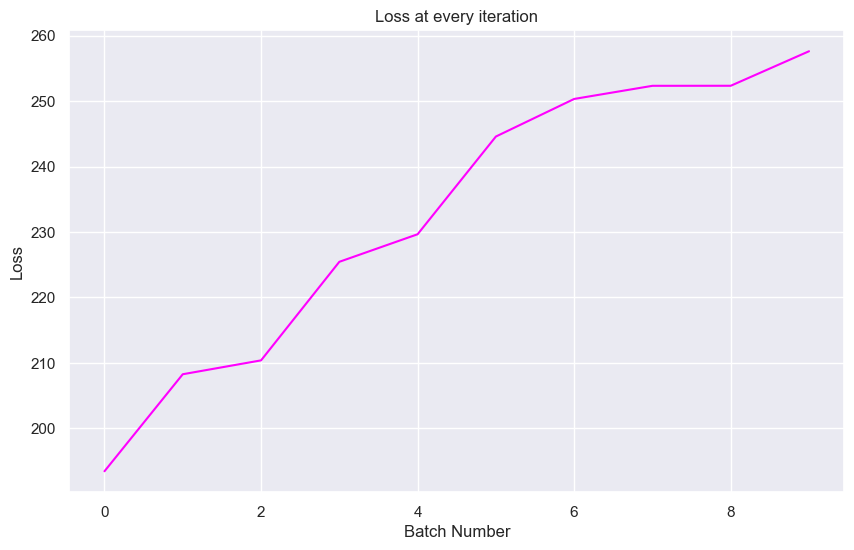

Training complete. Time (mins):  3.8619749347368875


In [81]:
# # ************************************************************************
# # *********     FROM BLANK MODEL:
# # *********     Train the recognizer with Stochastic GD
# # ************************************************************************

# st = time.time()

# # create blank Language class
# spacy.prefer_gpu()
# nlp = spacy.blank('en')  
# print("Created blank 'en' model")

# # create the built-in pipeline components and add them to the pipeline
# if 'ner' not in nlp.pipe_names:
#     ner = nlp.create_pipe('ner')
#     nlp.add_pipe("ner")
# else:
#     ner = nlp.get_pipe('ner')
    
# # Add labels
# for ent_type in ent_labels:
#     ner.add_label(ent_type)
# print("Entities added to new 'ner'.")

# # Disable all pipes other than 'ner' during training
# other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

# # only train NER pipe
# with nlp.disable_pipes(*other_pipes):  
#     optimizer = nlp.begin_training()
    
#     train_loss = []
#     idx_done = 0
#     for itn in range(iterations):
#         print("Starting iteration " + str(itn))
        
#         # Iteration level metrics
#         losses = {}
#         misalligned_count = 0
        
#         # Shuffle training data
#         random.shuffle(spacy_training_data)

#         #batches = minibatch(spacy_training_data, size=compounding(4., 32., 1.001))
#         batches = minibatch(spacy_training_data, size=batch_size)

#         batch_no = 0
#         for batch in batches:
#             print("Starting batch " + str(batch_no))
#             for text, annotations in tqdm.tqdm(batch):
#                 # create Example
#                 doc = nlp.make_doc(text)
#                 example = Example.from_dict(doc, annotations)
#                 # Update the model
#                 nlp.update([example], sgd=optimizer, drop=0.35, losses=losses)
#                 # print('Losses', losses)
#                 idx_done+=1
          
#             # Documenting the loss
#             train_loss.append(losses.get('ner'))
#             print(f'losses (batch {itn}): {losses}')
#             batch_no+=1

#             # !CHECKPOINT!
#             # Save our trained model into a new directory
#             save_fp = model_save_path + "/save_model/"
#             if not os.path.isdir(save_fp):
#                 os.makedirs(save_fp)
#             else:
#                 shutil.rmtree(save_fp)
#                 os.makedirs(save_fp)
#             now = datetime.now()
#             fn = "course_nlp___idx_{}__{}".format(str(idx_done), str(now.strftime("%Y_%m_%d__%I_%M_%S_%p")))
#             nlp.to_disk(save_fp + fn)
            
#             print("Checkpoint saved: ", str(save_fp + fn))
        
#     # Visualizing the loss
#     plt.figure(figsize=(10,6))
#     plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
#     plt.title('Loss at every iteration')
#     plt.xlabel('Batch Number')
#     plt.ylabel('Loss')
#     plt.show()

# print("Training complete. Time (mins): ", (time.time() - st)/60)

### Resume Training!

In [131]:
# SET


SET_TRAIN_SIZE = 1300000
SET_BATCH_SIZE = 100000

In [132]:
# :: settings ::

last_index, last_save_model_fp = get_last_model_fp()

# id done till now, need to resume from ??
idx_done_tillnow = int(last_index)
train_begin, train_end =  idx_done_tillnow, idx_done_tillnow + SET_TRAIN_SIZE + 1

# training data
spacy_training_data = train_data[train_begin: train_end]

# creating batches of training data
batch_size = SET_BATCH_SIZE

# Go through the training data N times
iterations = 1

# Save output nlp model
model_save_path = ml_dir + '/models/spacy/courseNER'

# entity labels
ent_labels = {'COURSE_ID', 'COURSE_NAME', 'COURSE_DEPT'}

Loaded last saved model from  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1210004__2023_03_08__01_23_06_AM
Starting iteration 0
Starting batch 0


100%|███████████████████████████████████| 100000/100000 [48:53<00:00, 34.09it/s]


losses (batch 0): {'ner': 76.46575019732454}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1310004__2023_03_08__04_17_13_AM
Starting batch 1


100%|███████████████████████████████████| 100000/100000 [56:45<00:00, 29.36it/s]


losses (batch 0): {'ner': 123.79358323341755}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1410004__2023_03_08__05_14_00_AM
Starting batch 2


100%|███████████████████████████████████| 100000/100000 [50:40<00:00, 32.89it/s]


losses (batch 0): {'ner': 221.52084453124036}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1510004__2023_03_08__06_04_40_AM
Starting batch 3


100%|███████████████████████████████████| 100000/100000 [47:16<00:00, 35.25it/s]


losses (batch 0): {'ner': 306.2661419173445}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1610004__2023_03_08__06_51_57_AM
Starting batch 4


100%|███████████████████████████████████| 100000/100000 [43:56<00:00, 37.93it/s]


losses (batch 0): {'ner': 396.55904353004246}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1710004__2023_03_08__07_35_53_AM
Starting batch 5


100%|███████████████████████████████████| 100000/100000 [42:19<00:00, 39.38it/s]


losses (batch 0): {'ner': 457.9102198319484}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1810004__2023_03_08__08_18_13_AM
Starting batch 6


100%|███████████████████████████████████| 100000/100000 [48:21<00:00, 34.46it/s]


losses (batch 0): {'ner': 499.8832129264054}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_1910004__2023_03_08__09_06_34_AM
Starting batch 7


100%|███████████████████████████████████| 100000/100000 [47:03<00:00, 35.42it/s]


losses (batch 0): {'ner': 563.9771940567856}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_2010004__2023_03_08__09_53_37_AM
Starting batch 8


100%|█████████████████████████████████| 100000/100000 [3:07:24<00:00,  8.89it/s]


losses (batch 0): {'ner': 640.6698696467514}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_2110004__2023_03_08__01_01_02_PM
Starting batch 9


100%|█████████████████████████████████| 100000/100000 [3:27:02<00:00,  8.05it/s]


losses (batch 0): {'ner': 746.156691110955}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_2210004__2023_03_08__04_28_04_PM
Starting batch 10


100%|█████████████████████████████████| 100000/100000 [3:14:30<00:00,  8.57it/s]


losses (batch 0): {'ner': 820.3373554531923}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_2310004__2023_03_08__07_42_36_PM
Starting batch 11


100%|███████████████████████████████████| 100000/100000 [54:43<00:00, 30.46it/s]


losses (batch 0): {'ner': 861.2569945223812}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_2410004__2023_03_08__08_37_20_PM
Starting batch 12


100%|███████████████████████████████████| 100000/100000 [53:20<00:00, 31.25it/s]


losses (batch 0): {'ner': 948.6410226395308}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_2510004__2023_03_08__09_30_41_PM
Starting batch 13


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]


losses (batch 0): {'ner': 948.6410226395308}
Checkpoint saved:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_2510005__2023_03_08__09_30_41_PM


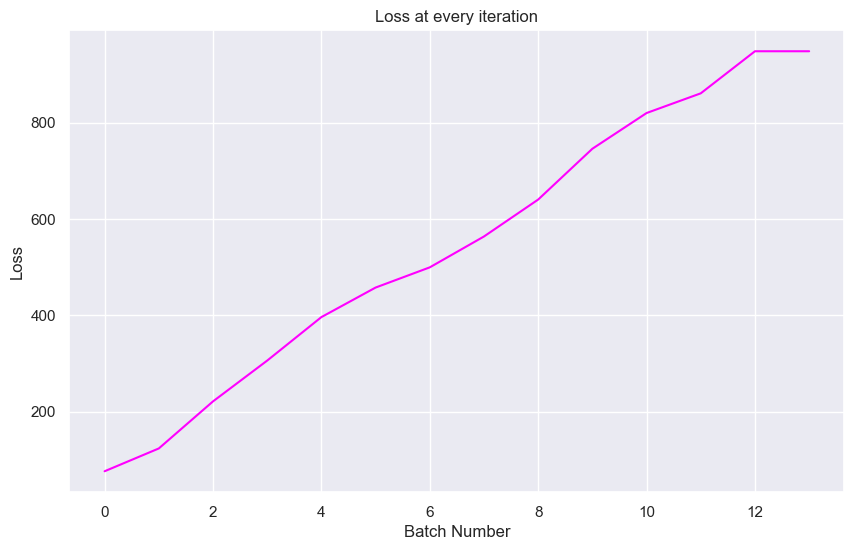

Training complete. Time (mins):  1082.390098253886


In [133]:
# ************************************************************************
# *********     RESUME TRAINING!
# *********     
# ************************************************************************

st = time.time()

# load last save nlp model
spacy.prefer_gpu()
nlp = spacy.load(last_save_model_fp)
ner = nlp.get_pipe('ner')
print("Loaded last saved model from ", last_save_model_fp)

# Disable all pipes other than 'ner' during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

# only train NER pipe
with nlp.disable_pipes(*other_pipes):
    train_loss = []
    idx_done = idx_done_tillnow
    for itn in range(iterations):
        print("Starting iteration " + str(itn))
        
        # Iteration level metrics
        losses = {}
        misalligned_count = 0
        
        # Shuffle training data
        random.shuffle(spacy_training_data)

        #batches = minibatch(spacy_training_data, size=compounding(4., 32., 1.001))
        batches = minibatch(spacy_training_data, size=batch_size)

        batch_no = 0
        for batch in batches:
            print("Starting batch " + str(batch_no))
            for text, annotations in tqdm.tqdm(batch):
                # create Example
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annotations)
                # Update the model
                nlp.update([example], sgd=optimizer, drop=0.35, losses=losses)
                # print('Losses', losses)
                idx_done+=1
          
            # Documenting the loss
            train_loss.append(losses.get('ner'))
            print(f'losses (batch {itn}): {losses}')
            batch_no+=1

            # CHECKPOINT:
            # Save our trained model into a new directory
            save_fp = model_save_path + "/save_model/"
            if not os.path.isdir(save_fp):
                os.makedirs(save_fp)
            else:
                shutil.rmtree(save_fp)
                os.makedirs(save_fp)
            now = datetime.now()
            fn = "course_nlp___idx_{}__{}".format(str(idx_done), str(now.strftime("%Y_%m_%d__%I_%M_%S_%p")))
            nlp.to_disk(save_fp + fn)
            print("Checkpoint saved: ", str(save_fp + fn))
        
    # Visualizing the loss
    plt.figure(figsize=(10,6))
    plt.plot([*range(len(train_loss))], train_loss, color = 'magenta')
    plt.title('Loss at every iteration')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.show()

print("Training complete. Time (mins): ", (time.time() - st)/60)

---

## Approach 2

In [39]:
# l=set()
# # Add labels
# for _, annotations in train_data:
#      for ent in annotations.get('entities'):
#         l.add(ent[2])

# # Step 3:
# # Save training data in Spacy readable format DocBin
# # error fix: https://github.com/explosion/spaCy/discussions/10255

# # will make 51 "train_{idx}.spacy" DocBin files
# chunk_size = 100000  
# # saves failed attempts
# c, failed, empty = 0, [], []
# for idx in range(0, len(train_data), chunk_size):
#     training_lst = train_data[idx: idx + chunk_size]
#     db = DocBin()
#     for text, annot in tqdm.tqdm(training_lst): # data in previous format
#         try:
#             # create doc object from text
#             doc = nlp.make_doc(text)
#             ents = []
#             for start, end, label in annot["entities"]:
#                 span = doc.char_span(start, end, label=label, alignment_mode="contract")
#                 if span is None:
#                     empty.append((c, text, annot))
#                 else:
#                     ents.append(span)
#             doc.ents = ents # label the text with the ents
#             db.add(doc)
#         except Exception as e:
#             failed.append((c, text, annot))
#         c+=1

#     # save the docbin object
#     db.to_disk(os.path.join(os.path.join(os.path.join(ml_dir, "data"), "train_ner"), "train_{}.spacy".format(idx)))

# print("Number of total empty spans found:", len(empty))
# print("Number of total failed attempts: ", len(failed))

100%|███████████████████████████████████| 60960/60960 [00:09<00:00, 6232.99it/s]


Number of total empty spans found: 1738
Number of total failed attempts:  0


In [42]:
# Step 4: 
# download config file from: https://spacy.io/usage/training#quickstart 
# and store it in "../data/"

In [107]:
# # Step 5:
# # Complete the cofig file using original nlp file

# !python -m spacy init fill-config ../data/base_config.cfg ../data/config.cfg

In [108]:
# # Step 6:
# # Train model

# st = time.time()
# !python -m spacy train ../data/config.cfg --output ../models/spacy/customNER2 --paths.train ../data/train_ner --paths.dev ../data/train_ner --verbose
# print("Total time taken (mins): ", (time.time()-st)/60)

----

# Testing

In [72]:
def extract_ents(course_nlp, query, visualize = False):
    doc = course_nlp(query)    
    extracted_entities = []
    for ent in doc.ents:
        extracted_entities.append((ent.text, ent.start_char, ent.end_char, ent.label_))
    # if visualize
    if visualize == True:
        colors = {"COURSE_ID": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
                  "COURSE_NAME": "linear-gradient(90deg, #85C1E9, #85C1E8)",
                  "COURSE_DEPT": "linear-gradient(90deg, #85C1F9, #85C1F9)"}
        options = {"ents": ["COURSE_ID", "COURSE_NAME", "COURSE_DEPT"], "colors": colors}
        html = displacy.render(doc, style = 'ent', options = options)
    return extracted_entities

In [68]:
query = "What are the similar courses to ACCT 3320 offered this semester?"


# run
_, m = get_last_model_fp()
course_nlp = spacy.load(m)
extract_ents(course_nlp, query, visualize = True)

[('ACCT 3320', 50, 59, 'COURSE_ID')]

In [74]:
os.listdir(model_save_path + '/save_model/course_nlp___idx_3000__2023_03_07__10_27_05_AM')

['course_nlp___idx_3000__2023_03_07__10_27_05_AM']

In [78]:
query = "What are some similar courses to Readings in World History?"


# run
_, m = get_last_model_fp()
course_nlp = spacy.load(m)
extract_ents(course_nlp, query, visualize = True)

[('ACCT 3320 offered this', 32, 54, 'COURSE_NAME')]

In [106]:
get_last_model_fp()

('10000',
 '/Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/models/spacy/courseNER/save_model/course_nlp___idx_10000__2023_03_07__10_38_49_AM')

----

X-X

----